# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn

#new 
from nltk.tokenize.casual import casual_tokenize #casual_tokenize(text, preserve_case=True, reduce_len=False, strip_handles=False)
from nltk.tokenize import TreebankWordTokenizer

# Own functions
from FeatureFunctions import *

%matplotlib inline

# Notebook Setup

This notebook is used to analyse the influence different tokeization techniques have on the L2-regularized Logistic Regression that was used in the underlying paper. To that end the whole feature generation task and some auxillariy fucntions weresummarized in FeatureFunctions.py.
 
The POS-tagger is using the same tokenization as the general tokenization.
The choices in generating a TweetsDataset are:
    - the data: a path to a csv
    - tokenizer_name : 'orig' uses the same as before, 'words' does work tokenization, 'casual_std' is the tweet tokenizer from nltk, 'casual_reduce' is the tweet tokenizer from nltk with some additional simplifications (see https://www.nltk.org/_modules/nltk/tokenize/casual.html)
    - use_stopwords: True or False
    - min_df, max_df, max_ngram: govern the vocab size (see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
    
Now, the data can be genrated as in the underlying paper, only changing tokenization technnique. The same snippets of code wil be run with different tokenization techniques. Other changebale parameters are kept the same throughout to ensure comparability.

In [2]:
#Save data to folder
PREFIX = 'data/compareTokenization/'
MIN_DF = 5
MAX_DF = 0.75
MAX_NGRAM = 3
USE_STOPWORDS = True
USE_PREPROCESS = False

# Char-tokenization


## Get Features

In [3]:
TOKENIZER = 'orig'
data = TweetsDataset(csv_path =  "../data/labeled_data.csv", tokenizer_name = TOKENIZER, use_stopwords = USE_STOPWORDS, use_preprocessor= USE_PREPROCESS, min_df = MIN_DF, max_df = MAX_DF, max_ngram = MAX_NGRAM)
X = data.features
y = data.labels

A vocab was created. It consists of 9795 entries

 Data has been processed and is now available. Feature dim: (24783, 10369)


## Build model


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [5]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01, solver ='liblinear', max_iter = 100))
X_train = select.fit_transform(X_train,y_train)
X_test = select.transform(X_test)
print(f'Deature dimension after dimensionality reduction: {X_train.shape}')

Deature dimension after dimensionality reduction: (22304, 647)


In [6]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01, solver = 'liblinear').fit(X_train,y_train)
y_preds = model.predict(X_test)

## Evaluating the results

In [7]:
report = classification_report( y_test, y_preds , output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'{PREFIX}{TOKENIZER}_report.csv')

In [8]:
report_df

,precision,recall,f1-score,support
0,0.386598,0.457317,0.418994,164.000000
1,0.950055,0.898688,0.923658,1905.000000
2,0.776398,0.914634,0.839866,410.000000
accuracy,0.872126,0.872126,0.872126,0.872126
macro avg,0.704350,0.756880,0.727506,2479.000000
weighted avg,0.884058,0.872126,0.876413,2479.000000


Confusionmatrix was saved to data/compareTokenization/orig_confusion.png


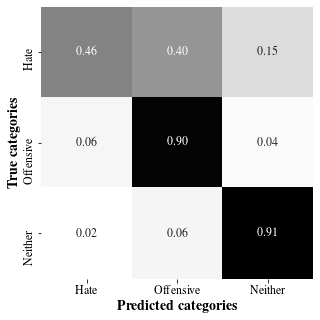

In [9]:
print_cm(y_test,y_preds, save_cm = True, save_path = (f'{PREFIX}{TOKENIZER}_confusion.png'))

# Word-tokenization


## Get Features

In [10]:
TOKENIZER = 'words'
data = TweetsDataset(csv_path =  "../data/labeled_data.csv", tokenizer_name = TOKENIZER, use_stopwords = USE_STOPWORDS, use_preprocessor= USE_PREPROCESS, min_df = MIN_DF, max_df = MAX_DF, max_ngram = MAX_NGRAM)
X = data.features
y = data.labels

A vocab was created. It consists of 10000 entries

 Data has been processed and is now available. Feature dim: (24783, 13760)


## Build model


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [12]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01, solver ='liblinear', max_iter = 100))
X_train = select.fit_transform(X_train,y_train)
X_test = select.transform(X_test)
print(f'Deature dimension after dimensionality reduction: {X_train.shape}')

Deature dimension after dimensionality reduction: (22304, 248)


In [13]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01, solver = 'liblinear').fit(X_train,y_train)
y_preds = model.predict(X_test)

## Evaluating the results

In [14]:
report = classification_report( y_test, y_preds , output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'{PREFIX}{TOKENIZER}_report.csv')

In [15]:
report_df

,precision,recall,f1-score,support
0,0.459184,0.548780,0.500000,164.000000
1,0.957889,0.895538,0.925665,1905.000000
2,0.758964,0.929268,0.835526,410.000000
accuracy,0.878177,0.878177,0.878177,0.878177
macro avg,0.725346,0.791196,0.753730,2479.000000
weighted avg,0.891997,0.878177,0.882597,2479.000000


Confusionmatrix was saved to data/compareTokenization/words_confusion.png


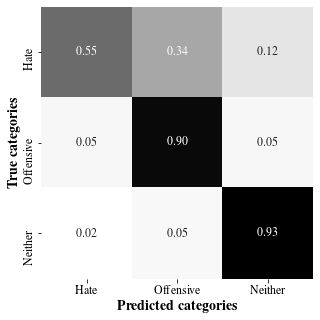

In [16]:
print_cm(y_test,y_preds, save_cm = True, save_path = (f'{PREFIX}{TOKENIZER}_confusion.png'))

# Casual-tokenization
- (Casual Standard)

## Get Features

In [17]:
TOKENIZER = 'casual_std'
data = TweetsDataset(csv_path =  "../data/labeled_data.csv", tokenizer_name = TOKENIZER, use_stopwords = USE_STOPWORDS, use_preprocessor= USE_PREPROCESS, min_df = MIN_DF, max_df = MAX_DF, max_ngram = MAX_NGRAM)
X = data.features
y = data.labels

A vocab was created. It consists of 10000 entries

 Data has been processed and is now available. Feature dim: (24783, 15017)


## Build model


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [19]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01, solver ='liblinear', max_iter = 100))
X_train = select.fit_transform(X_train,y_train)
X_test = select.transform(X_test)
print(f'Deature dimension after dimensionality reduction: {X_train.shape}')

Deature dimension after dimensionality reduction: (22304, 264)


In [20]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01, solver = 'liblinear').fit(X_train,y_train)
y_preds = model.predict(X_test)

## Evaluating the results

In [21]:
report = classification_report( y_test, y_preds , output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'{PREFIX}{TOKENIZER}_report.csv')

In [22]:
report_df

,precision,recall,f1-score,support
0,0.443925,0.579268,0.502646,164.000000
1,0.959819,0.890289,0.923747,1905.000000
2,0.773092,0.939024,0.848018,410.000000
accuracy,0.877773,0.877773,0.877773,0.877773
macro avg,0.725612,0.802860,0.758137,2479.000000
weighted avg,0.894807,0.877773,0.883364,2479.000000


Confusionmatrix was saved to data/compareTokenization/casual_std_confusion.png


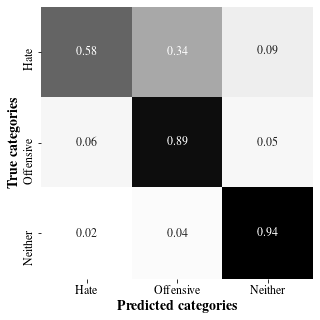

In [23]:
print_cm(y_test,y_preds, save_cm = True, save_path = (f'{PREFIX}{TOKENIZER}_confusion.png'))

# Casual-tokenization
- (Casual reduce)


## Get Features

In [24]:
TOKENIZER = 'casual_reduce'
data = TweetsDataset(csv_path =  "../data/labeled_data.csv", tokenizer_name = TOKENIZER, use_stopwords = USE_STOPWORDS, use_preprocessor= USE_PREPROCESS, min_df = MIN_DF, max_df = MAX_DF, max_ngram = MAX_NGRAM)
X = data.features
y = data.labels

A vocab was created. It consists of 10000 entries

 Data has been processed and is now available. Feature dim: (24783, 14737)


## Build model


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [26]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01, solver ='liblinear', max_iter = 100))
X_train = select.fit_transform(X_train,y_train)
X_test = select.transform(X_test)
print(f'Deature dimension after dimensionality reduction: {X_train.shape}')

Deature dimension after dimensionality reduction: (22304, 269)


In [27]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01, solver = 'liblinear').fit(X_train,y_train)
y_preds = model.predict(X_test)

## Evaluating the results

In [28]:
report = classification_report( y_test, y_preds , output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'{PREFIX}{TOKENIZER}_report.csv')

In [29]:
report_df

,precision,recall,f1-score,support
0,0.447115,0.567073,0.500000,164.00000
1,0.958804,0.891864,0.924123,1905.00000
2,0.773547,0.941463,0.849285,410.00000
accuracy,0.878580,0.878580,0.878580,0.87858
macro avg,0.726489,0.800133,0.757803,2479.00000
weighted avg,0.894313,0.878580,0.883687,2479.00000


Confusionmatrix was saved to data/compareTokenization/casual_reduce_confusion.png


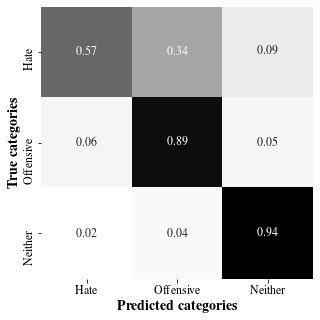

In [30]:
print_cm(y_test,y_preds, save_cm = True, save_path = (f'{PREFIX}{TOKENIZER}_confusion.png'))